In [1]:
!ls ../mnt

bloom-10000.joblib   domain_specific_words.json
bloom-100000.joblib  fsdp_exps
bloom-300000.joblib  grads_layer14_bloom-10000.joblib
bloom-600000.joblib  grads_layer3_bloom-10000.joblib
bloom-models	     openwebtext
data		     openwebtext_splits


In [4]:
stats_3

{0: [0.0006935425917617977, 0.07843219488859177, 0.7725496292114258]}

In [5]:
stats_14

{0: [0.19502665102481842]}

In [89]:
import joblib

word_stats_3 = joblib.load('../mnt/grads_layer3_bloom-10000.joblib') # OK
word_stats_14 = joblib.load('../mnt/grads_layer14_bloom-10000.joblib')


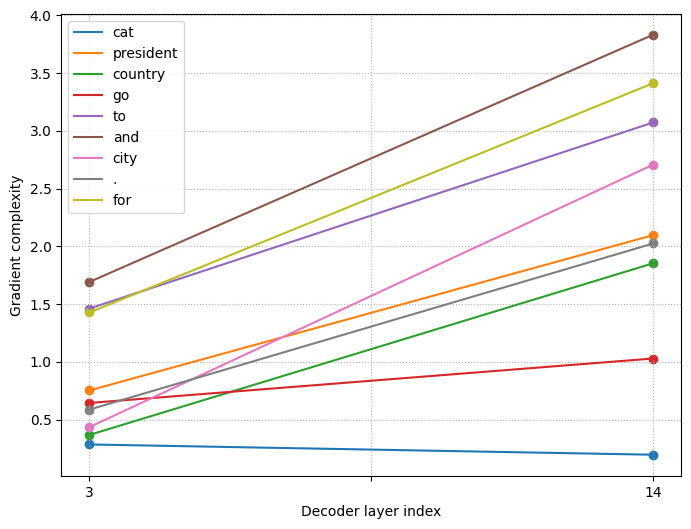

In [90]:
import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(8, 6))

# plt.yscale('log')

for word in ['cat', 'president', 'country', 'hi', 'go', 'to', 'and', 'I', 'city', '.', 'for']:
    if word not in word_stats_14:
        continue
        
    stats_3 = word_stats_3[word]
    stats_14 = word_stats_14[word]
    to_draw = [np.mean(np.nan_to_num(layer_stat)) for layer_stat in [list(stats_3.values()), list(stats_14.values())]]
    plt.plot(np.arange(len(to_draw)), to_draw, label=word)
    plt.scatter(np.arange(len(to_draw)), to_draw)

plt.xlabel('Decoder layer index')
plt.ylabel('Gradient complexity')
plt.xticks(np.arange(len(to_draw) + 1) / 2, [3, '', 14])
plt.grid(ls=':')
plt.legend()

In [91]:
import joblib

word_stats_3_600k = joblib.load('../mnt/grads_layer3_bloom-600k.joblib') 
word_stats_14_600k = joblib.load('../mnt/grads_layer14_bloom-600k.joblib')


word_stats_3_10k = joblib.load('../mnt/grads_layer3_bloom-10000.joblib') # OK
word_stats_14_10k = joblib.load('../mnt/grads_layer14_bloom-10000.joblib')


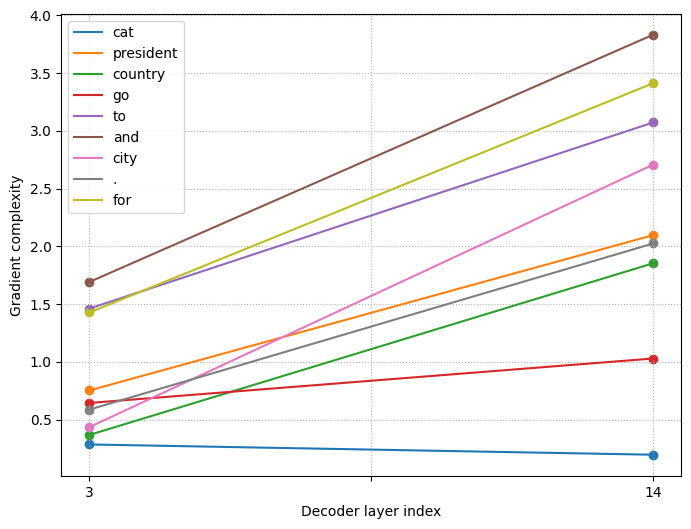

In [92]:
import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(8, 6))

# plt.yscale('log')

for word in ['cat', 'president', 'country', 'hi', 'go', 'to', 'and', 'I', 'city', '.', 'for']:
    if word not in word_stats_14:
        continue
        
    stats_3 = word_stats_3[word]
    stats_14 = word_stats_14[word]
    to_draw = [np.mean(np.nan_to_num(layer_stat)) for layer_stat in [list(stats_3.values()), list(stats_14.values())]]
    plt.plot(np.arange(len(to_draw)), to_draw, label=word)
    plt.scatter(np.arange(len(to_draw)), to_draw)

plt.xlabel('Decoder layer index')
plt.ylabel('Gradient complexity')
plt.xticks(np.arange(len(to_draw) + 1) / 2, [3, '', 14])
plt.grid(ls=':')
plt.legend()

In [93]:
from copy import deepcopy

In [94]:
word_stats_10k = deepcopy(word_stats_3_10k)
to_pop = []

for k in word_stats_10k:
    if k in word_stats_14_10k:
        word_stats_10k[k][1] = word_stats_14_10k[k][0]
    else:
        to_pop.append(k)

for k in to_pop:
    word_stats_10k.pop(k)

In [95]:
word_stats_600k = deepcopy(word_stats_3_600k)
to_pop = []

for k in word_stats_600k:
    if k in word_stats_14_600k:
        word_stats_600k[k][1] = word_stats_14_600k[k][0]
    else:
        to_pop.append(k)

for k in to_pop:
    word_stats_600k.pop(k)

In [96]:
layer_indices = [3, 14]

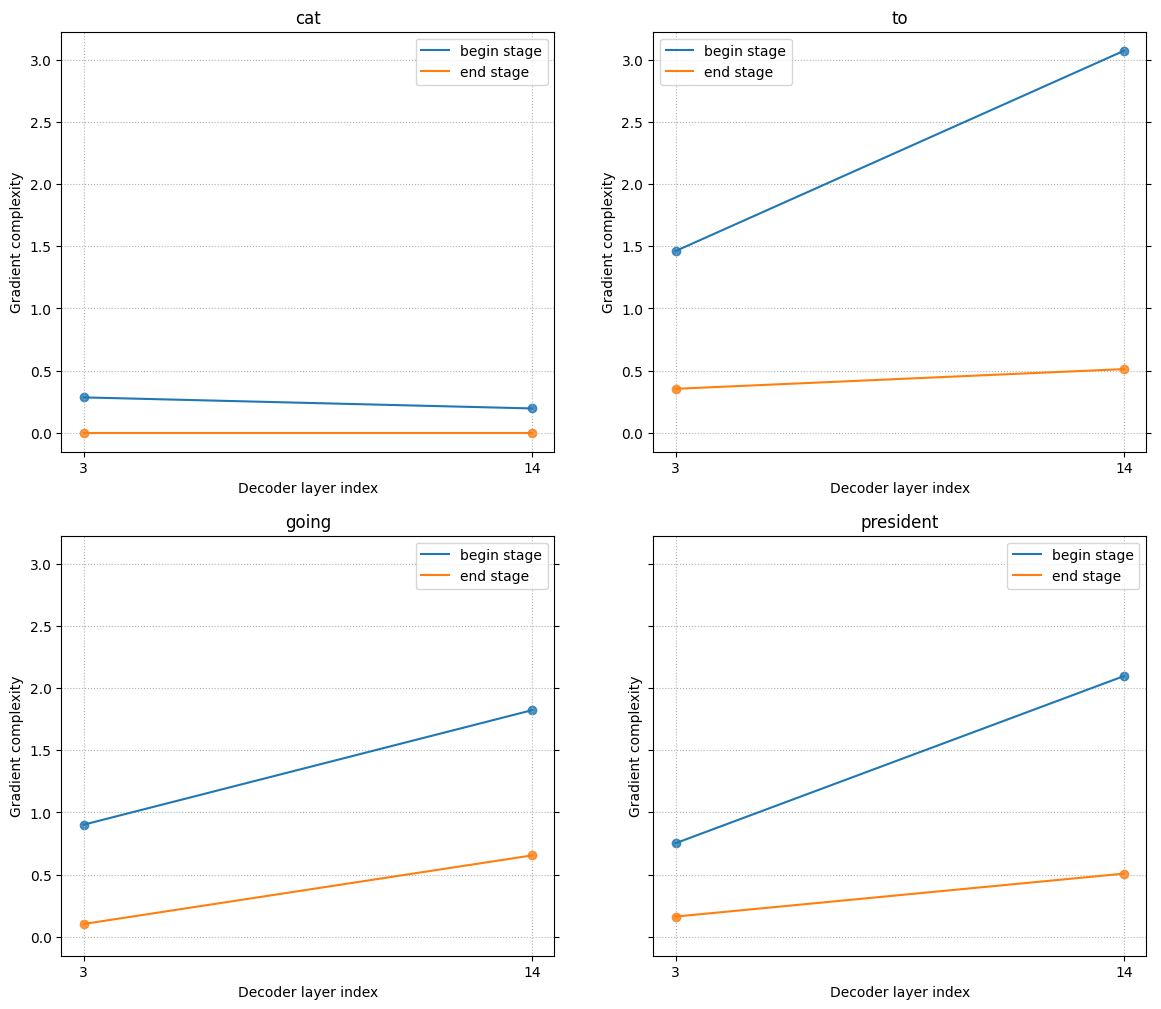

In [97]:
import joblib

# word_stats = joblib.load('files/word_stats_dict.joblib')

import matplotlib.pyplot as plt

import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12), sharey='all')

for word, ax in zip(['cat', 'to', 'going', 'president'], axes.ravel()):
    
    for word_stats, name in zip([word_stats_10k, word_stats_600k],
                                ['begin stage', 'end stage']):
        
        stats = word_stats[word]

        to_draw = [np.mean(np.nan_to_num(layer_stat)) for layer_stat in stats.values()]
        ax.plot(np.arange(len(stats)), to_draw, label=name)
        ax.scatter(np.arange(len(stats)), to_draw, alpha=0.8)

    ax.legend()
    ax.set_xticks(np.arange(len(to_draw)), layer_indices)
    ax.set_title(word)
    ax.set_xlabel('Decoder layer index')
    ax.set_ylabel('Gradient complexity')
    if word in ['to', 'going']:
        ax.tick_params('y', reset=True)
    ax.grid(ls=':')

plt.show()

In [98]:
import json
domain_words = json.load(open('./domain_specific_words.json', 'r'))

from collections import defaultdict

domain_words.pop('architecture')
model_results = defaultdict(dict)


In [99]:
for name, stats in zip(['bloom-10k', 'bloom-600k',], 
                        [word_stats_10k, word_stats_600k]):
    for domain_group, words in domain_words.items():
        word_means = np.zeros(2)
        counter = 0
        for word in words:
            if word not in stats:
                continue
            word_stats = stats[word]
            to_draw = np.array([np.mean(np.nan_to_num(layer_stat)) for layer_stat in word_stats.values()])
            counter += 1
            word_means += to_draw
        if counter < 5:
            print(f'{domain_group} is poorly present, skip...')
            continue
        
        word_means = word_means / counter
        model_results[name][domain_group] = word_means

In [100]:
names = ['bloom-10k', 'bloom-600k', ]

In [101]:
layers = [3, 14]

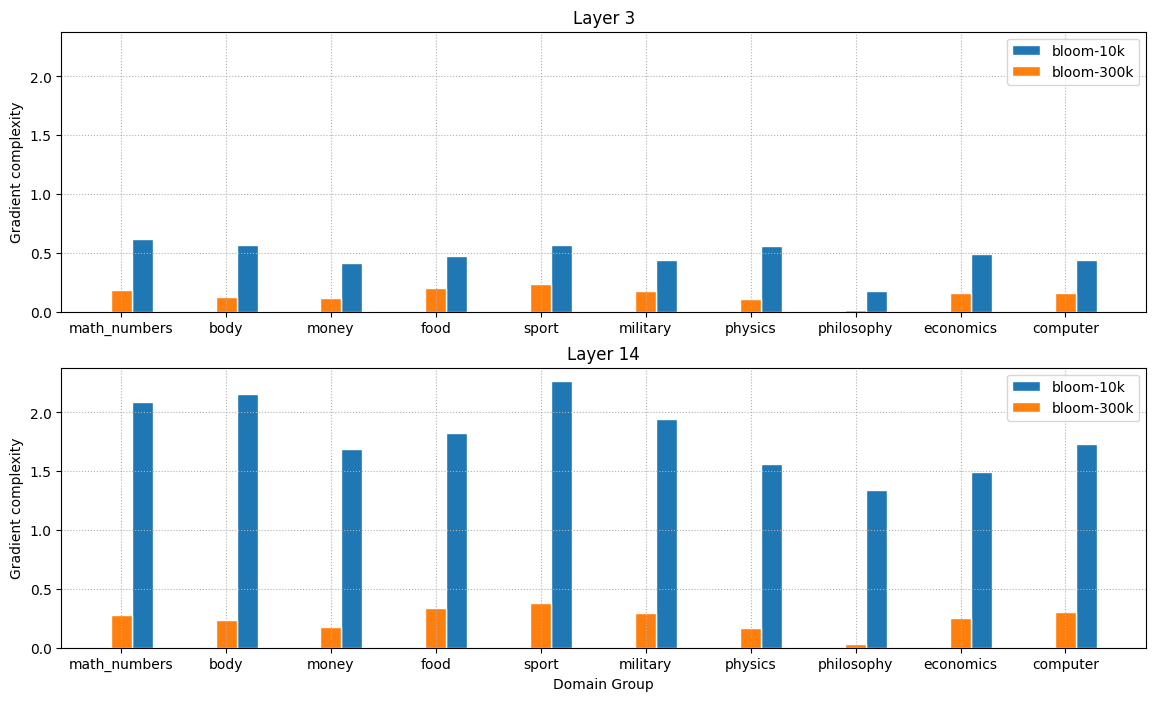

In [102]:
layer_model_results = defaultdict(lambda: defaultdict(list))
x = []

for name in names:
    for domain_group in domain_words:
        if domain_group not in x:
            x.append(domain_group)
        domain_specific_results = model_results[name][domain_group]
        for i, layer in enumerate(layers):
            layer_model_results[layer][name].append(domain_specific_results[i])
    

x_axis = np.arange(len(x))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharey='all')

for i, layer in enumerate(layers):
    ax = axes.ravel()[i]
    plt.title(f'layer {layer} domain groups difficulty')
    
    for j, (k, v) in enumerate(layer_model_results[layer].items()):
        if '600'  in k:
            k = k.replace('600', '300')

        ax.bar(x_axis + 0.2 * (1 - j), v, 0.2, label=k, edgecolor="white")
    
    ax.set_title(f'Layer {layer}')
    ax.set_xticks(x_axis, x)
    ax.set_ylabel('Gradient complexity')
    ax.legend(loc='best')
    ax.grid(ls=':')
    
ax.set_xlabel('Domain Group')
plt.show()

In [103]:
general_words_dict = {
    'prepositions': ['to', 'in', 'at', 'on', 'out', 'between', 'before', 'after', 'for'],
    'verbs': ['is', 'make', 'has', 'do', 'say', 'get', 'make', 'go', 'take', 'want', 'come', 'kill'],
    'nouns': ['time', 'person', 'year', 'way', 'thing', 'building', 'man', 'group', 'state', 'cat'],
    'adjectives': ['stable', 'good', 'accurate', 'busy', 'clear', 'new', 'long', 'little', 'last'],
    'adverbs': ['completely', 'fully', 'often', 'rarely', 'outside', 'quickly', 'late'],
    'pronouns': ['i', 'me', 'my', 'he', 'she', 'it', 'his', 'her', 'they', 'their', 'you', 'yours']
}
model_results = defaultdict(dict) 
for name, stats in zip(['bloom-10k', 'bloom-600k'], 
                        [word_stats_10k, word_stats_600k]):
    for domain_group, words in general_words_dict.items():
        word_means = np.zeros(2)
        counter = 0
        for word in words:
            if word not in stats:
                continue
            word_stats = stats[word]
            to_draw = np.array([np.mean(np.nan_to_num(layer_stat)) for layer_stat in word_stats.values()])
            counter += 1
            word_means += to_draw
        if counter < 5:
            print(f'{domain_group} is poorly present, skip...')
            continue
        
        word_means = word_means / counter
        model_results[name][domain_group] = word_means

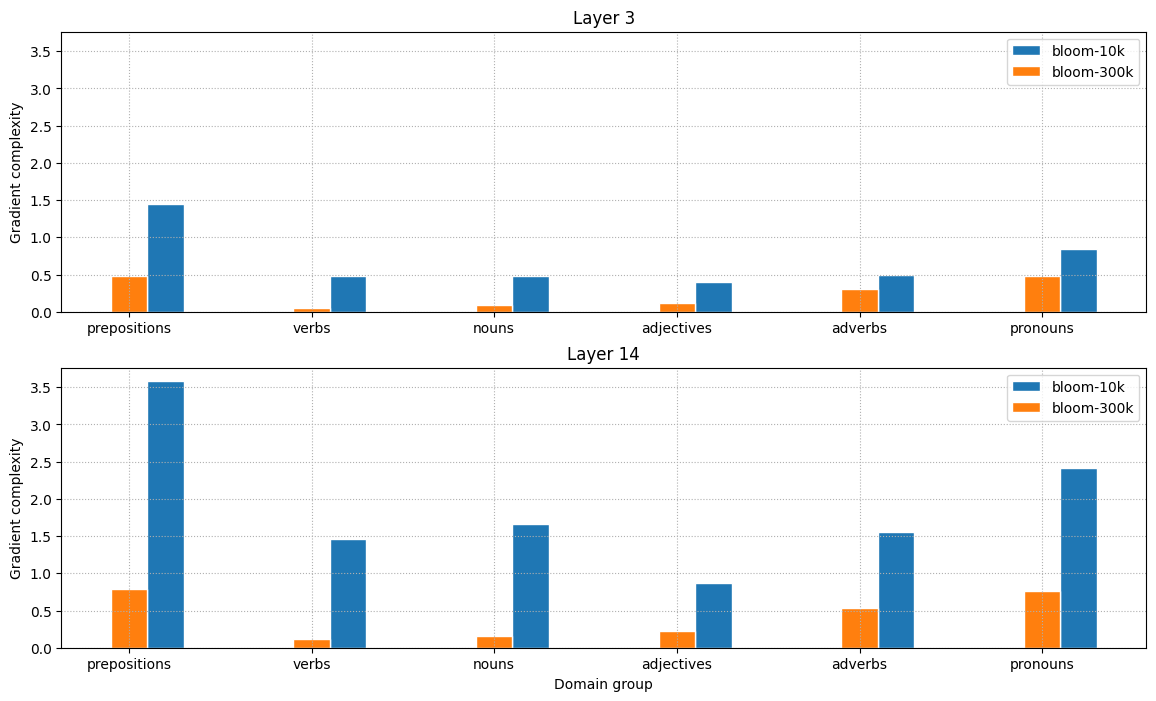

In [104]:
layer_model_results = defaultdict(lambda: defaultdict(list))
x = []

for name in names:
    for domain_group in general_words_dict:
        if domain_group not in x:
            x.append(domain_group)
        domain_specific_results = model_results[name][domain_group]
        for i, layer in enumerate(layers):
            layer_model_results[layer][name].append(domain_specific_results[i])
    

x_axis = np.arange(len(x))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharey='all')

for i, layer in enumerate(layers):
    ax = axes.ravel()[i]
    plt.title(f'layer {layer} domain groups difficulty')
    
    for j, (k, v) in enumerate(layer_model_results[layer].items()):
        if '600'  in k:
            k = k.replace('600', '300')
        ax.bar(x_axis + 0.2 * (1 - j), v, 0.2, label=k, edgecolor="white")
    
    ax.set_title(f'Layer {layer}')
    ax.set_xticks(x_axis, x)
    ax.set_ylabel('Gradient complexity')
    ax.legend(loc='upper right')
    ax.grid(ls=':')
    
ax.set_xlabel('Domain group')
plt.show()